In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import string, os 
import tensorflow as tf

# keras module for building LSTM 
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dropout, LSTM, Dense, Bidirectional 
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential

import matplotlib.pyplot as plt
import seaborn as sns
import io
import os
import re
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/colab_data'

Mounted at /content/drive


In [2]:
dataset = pd.read_csv(os.path.join(path, "taylor_swift_lyrics.csv"), encoding= 'unicode_escape')

In [3]:
def processFirstLine(lyrics, songID, songName, row):
    lyrics.append(row['lyric'] + '.\n')
    songID.append( row['year']*100+ row['track_n'])
    songName.append(row['track_title'])
    return lyrics,songID,songName
# define empty lists for the lyrics , songID , songName 
lyrics = []
songID = []
songName = []

# songNumber indicates the song number in the dataset
songNumber = 1

# i indicates the song number
i = 0
isFirstLine = True

# Iterate through every lyrics line and join them together for each song independently 
for index,row in dataset.iterrows():
    if(songNumber == row['track_n']):
        if (isFirstLine):
            lyrics,songID,songName = processFirstLine(lyrics,songID,songName,row)
            isFirstLine = False
        else :
            #if we still in the same song , keep joining the lyrics lines    
            lyrics[i] +=  row['lyric'] + '.\n'
    #When it's done joining a song's lyrics lines , go to the next song :    
    else :
        lyrics,songID,songName = processFirstLine(lyrics,songID,songName,row)
        songNumber = row['track_n']
        i+=1

# Define a new pandas DataFrame to save songID , songName , Lyrics in it to use them later
lyrics_data = pd.DataFrame({'songID':songID, 'songName':songName, 'lyrics':lyrics })

# Data Processing

In [4]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lyrics_data['lyrics'].astype(str).str.lower())

total_words = len(tokenizer.word_index)+1
tokenized_sentences = tokenizer.texts_to_sequences(lyrics_data['lyrics'].astype(str))
tokenized_sentences[0]

[61,
 58,
 3,
 86,
 10,
 318,
 115,
 604,
 194,
 263,
 1117,
 605,
 5,
 410,
 16,
 84,
 2,
 58,
 99,
 8,
 769,
 34,
 8,
 474,
 9,
 8,
 1472,
 606,
 16,
 62,
 8,
 1473,
 13,
 1118,
 1474,
 21,
 1475,
 43,
 84,
 4,
 2,
 27,
 90,
 80,
 1476,
 135,
 14,
 607,
 120,
 4,
 138,
 3,
 39,
 11,
 770,
 40,
 5,
 255,
 16,
 607,
 127,
 15,
 32,
 1,
 53,
 608,
 609,
 2,
 195,
 1,
 53,
 10,
 521,
 240,
 3,
 49,
 11,
 906,
 5,
 14,
 84,
 120,
 3,
 1119,
 19,
 8,
 1120,
 21,
 3,
 1121,
 32,
 1,
 53,
 907,
 2,
 195,
 1,
 53,
 16,
 128,
 411,
 175,
 53,
 13,
 10,
 222,
 21,
 12,
 908,
 4,
 10,
 241,
 771,
 318,
 564,
 32,
 1,
 53,
 608,
 609,
 2,
 195,
 1,
 53,
 13,
 6,
 1122,
 264,
 8,
 909,
 13,
 668,
 4,
 1477,
 522,
 16,
 1,
 910,
 83,
 5,
 50,
 6,
 19,
 16,
 15,
 9,
 8,
 1478,
 1123,
 10,
 669,
 17,
 8,
 911,
 16,
 1,
 35,
 440,
 121,
 670,
 1479,
 31,
 30,
 275,
 60,
 5,
 255,
 7,
 14,
 8,
 128,
 1480,
 4,
 1481,
 31,
 21,
 14,
 13,
 16,
 30,
 265,
 5,
 285,
 32,
 1,
 53,
 608,
 609,
 2,
 195,
 1,


In [5]:
# Slash sequences into n gram sequence
input_sequences = list()
for i in tokenized_sentences:
    for t in range(1, len(i)):
        n_gram_sequence = i[:t+1]
        input_sequences.append(n_gram_sequence)
        
# Pre padding
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

In [6]:
# create predictors and label
import tensorflow as tf
X, labels = input_sequences[:,:-1],input_sequences[:,-1]
y = tf.keras.utils.to_categorical(labels, num_classes=total_words)

# Model

In [7]:
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dropout, LSTM, Dense, Bidirectional 
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
# create model
model = Sequential()
model.add(Embedding(total_words, 40, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(250)))
model.add(Dropout(0.1))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
earlystop = EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='auto')
history = model.fit(X, y, epochs=10, verbose=1, callbacks=[earlystop])

Epoch 1/10
1106/1106 [==============================] - 119s 83ms/step - loss: 6.1095 - accuracy: 0.0515
Epoch 2/10
1106/1106 [==============================] - 93s 84ms/step - loss: 4.9787 - accuracy: 0.1229
Epoch 3/10
1106/1106 [==============================] - 93s 84ms/step - loss: 4.2001 - accuracy: 0.2086
Epoch 4/10
1106/1106 [==============================] - 94s 85ms/step - loss: 3.4920 - accuracy: 0.3115
Epoch 5/10
1106/1106 [==============================] - 94s 85ms/step - loss: 2.9017 - accuracy: 0.4110
Epoch 6/10
1106/1106 [==============================] - 93s 84ms/step - loss: 2.4131 - accuracy: 0.4952
Epoch 7/10
1106/1106 [==============================] - 93s 84ms/step - loss: 2.0615 - accuracy: 0.5659
Epoch 8/10
1106/1106 [==============================] - 93s 84ms/step - loss: 1.7673 - accuracy: 0.6188
Epoch 9/10
1106/1106 [==============================] - 93s 84ms/step - loss: 1.4998 - accuracy: 0.6733
Epoch 10/10
1106/1106 [==============================] - 93s 84

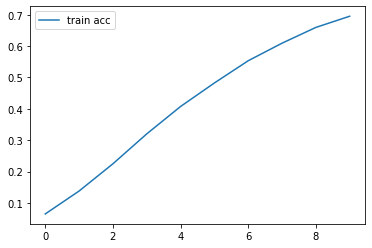

<Figure size 432x288 with 0 Axes>

In [8]:
# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

Generate New Songs

In [9]:
def complete_this_song(seed_text, next_words):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict_classes(token_list, verbose=0)
        
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

In [15]:
complete_this_song("on my baby", 140)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


"on my baby i got a smile and you walk me when i'm never take a beautiful town but i could dance in a motel little city and i had a bad feeling and i had a bad feeling but i am is from the curtains you made me down we fall the same we had it in the bathroom i was a m kiss to a money in a getaway car i was a dreamer of a bag of a yard of the mirror you said you walk the same and that's the weather i could hold on to you and i will hold on to you please don't ever become a stranger to the memories they will hold on to you whose laugh i could recognize anywhere hold on to the memories they will hold on to you whose laugh i"